<a href="https://colab.research.google.com/github/gpasxos/large-scale-optimization/blob/main/ch04_momentum_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

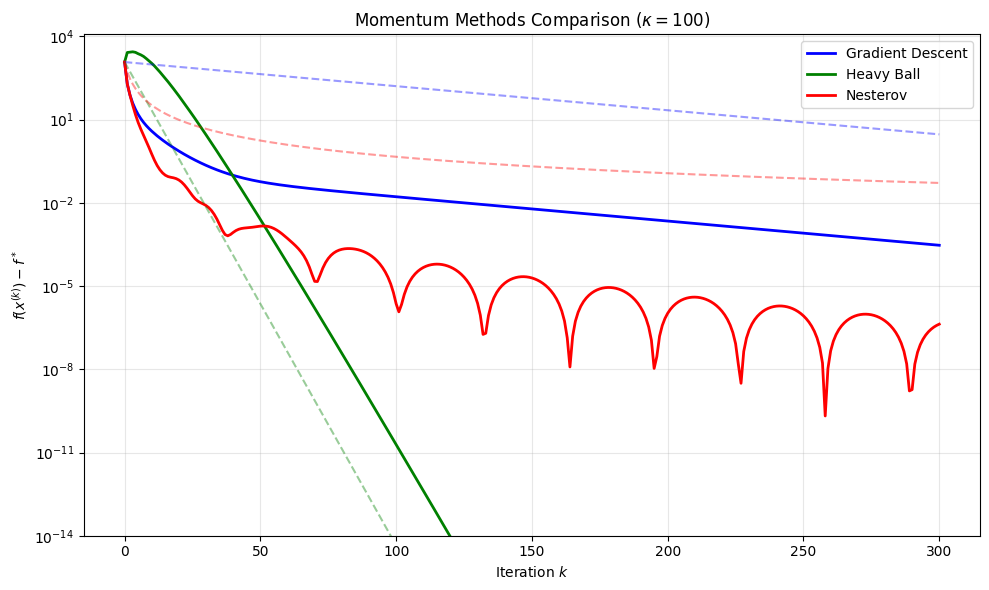

GD: 301 iterations to reach 1.19e-05
Heavy Ball: 65 iterations to reach 1.19e-05
Nesterov: 98 iterations to reach 1.19e-05


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def gradient_descent(Q, x0, eta, n_iters):
    """Standard gradient descent on f(x) = 0.5 * x'Qx."""
    x = x0.copy()
    errors = [0.5 * x @ Q @ x]
    for _ in range(n_iters):
        x = x - eta * (Q @ x)
        errors.append(0.5 * x @ Q @ x)
    return errors

def heavy_ball(Q, x0, eta, beta, n_iters):
    """Heavy ball method."""
    x = x0.copy()
    x_prev = x0.copy()
    errors = [0.5 * x @ Q @ x]
    for _ in range(n_iters):
        x_new = x - eta * (Q @ x) + beta * (x - x_prev)
        x_prev = x
        x = x_new
        errors.append(0.5 * x @ Q @ x)
    return errors

def nesterov(Q, x0, eta, n_iters):
    """Nesterov's accelerated gradient."""
    x = x0.copy()
    y = x0.copy()
    errors = [0.5 * x @ Q @ x]
    for k in range(n_iters):
        x_new = y - eta * (Q @ y)
        momentum = k / (k + 3)
        y = x_new + momentum * (x_new - x)
        x = x_new
        errors.append(0.5 * x @ Q @ x)
    return errors

def compare_momentum_methods():
    """Compare GD, Heavy Ball, and Nesterov."""
    np.random.seed(42)
    n = 50

    # Ill-conditioned quadratic
    m, M = 1, 100
    kappa = M / m
    Q = np.diag(np.linspace(m, M, n))

    x0 = np.random.randn(n)
    n_iters = 300

    # Optimal parameters
    eta_gd = 1 / M
    eta_hb = 4 / (np.sqrt(M) + np.sqrt(m))**2
    beta_hb = ((np.sqrt(kappa) - 1) / (np.sqrt(kappa) + 1))**2
    eta_nest = 1 / M

    errors_gd = gradient_descent(Q, x0, eta_gd, n_iters)
    errors_hb = heavy_ball(Q, x0, eta_hb, beta_hb, n_iters)
    errors_nest = nesterov(Q, x0, eta_nest, n_iters)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.semilogy(errors_gd, 'b-', linewidth=2, label='Gradient Descent')
    ax.semilogy(errors_hb, 'g-', linewidth=2, label='Heavy Ball')
    ax.semilogy(errors_nest, 'r-', linewidth=2, label='Nesterov')

    # Theoretical rates
    k = np.arange(len(errors_gd))
    ax.semilogy(errors_gd[0] * ((kappa-1)/(kappa+1))**k, 'b--', alpha=0.4)
    ax.semilogy(errors_hb[0] * ((np.sqrt(kappa)-1)/(np.sqrt(kappa)+1))**(2*k), 'g--', alpha=0.4)
    ax.semilogy(errors_nest[0] * 4 / (k+2)**2, 'r--', alpha=0.4)

    ax.set_xlabel('Iteration $k$')
    ax.set_ylabel('$f(x^{(k)}) - f^*$')
    ax.set_title(f'Momentum Methods Comparison ($\\kappa = {int(kappa)}$)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim([1e-14, errors_gd[0] * 10])

    plt.tight_layout()
    plt.savefig('momentum_comparison.pdf', bbox_inches='tight')
    plt.show()

    # Print iteration counts
    target = 1e-8 * errors_gd[0]
    for name, errors in [('GD', errors_gd), ('Heavy Ball', errors_hb), ('Nesterov', errors_nest)]:
        iters = next((i for i, e in enumerate(errors) if e < target), len(errors))
        print(f"{name}: {iters} iterations to reach {target:.2e}")

compare_momentum_methods()

The Nesterov variant in the code achieves $O(1/k^2)$ (sublinear), while heavy ball with optimal parameters achieves $(1 - 1/\sqrt{\kappa})^k$ (linear). For strongly convex functions, linear convergence is much faster!

The fix: For strongly convex functions, Nesterov's method should use constant momentum $\beta = \frac{\sqrt{\kappa} - 1}{\sqrt{\kappa} + 1}$:

In [5]:
def nesterov_strongly_convex(Q, x0, eta, beta, n_iters):
    """Nesterov's accelerated gradient for strongly convex functions."""
    x = x0.copy()
    y = x0.copy()
    errors = [0.5 * x @ Q @ x]
    for k in range(n_iters):
        x_new = y - eta * (Q @ y)
        y = x_new + beta * (x_new - x)  # Constant momentum
        x = x_new
        errors.append(0.5 * x @ Q @ x)
    return errors